In [1]:
#import libraries

In [2]:
import numpy as np
import pandas as pd

In [3]:
d_train = pd.read_csv("data/train.csv")

In [4]:
#read only head
d_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
#cleaning data
d_train = d_train.drop('Name', axis=1)
d_train = d_train.drop('Ticket', axis=1)
d_train = d_train.drop('Cabin', axis=1)
d_train = d_train.drop('PassengerId', axis=1)

In [6]:
#take a look at the outcome variable: 'survival'
print(d_train['Survived'].value_counts())

0    549
1    342
Name: Survived, dtype: int64


In [7]:
#assign X as a dataframe of features and y as a series of the outcome variable
X = d_train.drop('Survived', axis=1)
y = d_train.Survived

In [8]:
print(pd.get_dummies(X['Embarked']).head(5))

   C  Q  S
0  0  0  1
1  1  0  0
2  0  0  1
3  0  0  1
4  0  0  1


In [9]:
X.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
5,3,male,NaN,0,0,8.4583,Q
6,1,male,54.0,0,0,51.8625,S
7,3,male,2.0,3,1,21.0750,S
8,3,female,27.0,0,2,11.1333,S
9,2,female,14.0,1,0,30.0708,C


In [10]:
all_cal = ['Sex', 'Embarked']

In [11]:
#impute all the categorical variables
def dummy_df(df, all_cal):
    for x in all_cal:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [12]:
X = dummy_df(X, all_cal)

In [13]:
print(X.head(3))

   Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  Embarked_C  \
0       3  22.0      1      0   7.2500           0         1           0   
1       1  38.0      1      0  71.2833           1         0           1   
2       3  26.0      0      0   7.9250           1         0           0   

   Embarked_Q  Embarked_S  
0           0           1  
1           0           0  
2           0           1  


In [14]:
#show how much data is missing
X.isnull().sum().sort_values(ascending=False)

Age           177
Embarked_S      0
Embarked_Q      0
Embarked_C      0
Sex_male        0
Sex_female      0
Fare            0
Parch           0
SibSp           0
Pclass          0
dtype: int64

In [15]:
# Impute missing values using sklean imputer library
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
imputer.fit(X)
X = pd.DataFrame(data=imputer.transform(X), columns=X.columns)

In [16]:
#show how much data is missing - after imputer
X.isnull().sum().sort_values(ascending=False)

Embarked_S    0
Embarked_Q    0
Embarked_C    0
Sex_male      0
Sex_female    0
Fare          0
Parch         0
SibSp         0
Age           0
Pclass        0
dtype: int64

In [17]:
#find outliers
def find_outliers(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

In [18]:
tukey_indices, tudey_values = find_outliers(X['Age'])
print(np.sort(tudey_values))

[  0.42   0.67   0.75   0.75   0.83   0.83   0.92   1.     1.     1.     1.
   1.     1.     1.     2.     2.     2.     2.     2.     2.     2.     2.
   2.     2.    55.    55.    55.5   56.    56.    56.    56.    57.    57.
  58.    58.    58.    58.    58.    59.    59.    60.    60.    60.    60.
  61.    61.    61.    62.    62.    62.    62.    63.    63.    64.    64.
  65.    65.    65.    66.    70.    70.    70.5   71.    71.    74.    80.  ]


In [19]:
#Kernel Density Estimation
from sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate

def find_kde(x):
    x_scaled = scale(list(map(float, x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw="scott", fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred < 0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    return outlier_ind, outlier_value

In [20]:
kde_indices, kde_values = find_kde(X['Age'])
print(np.sort(kde_values))

[ 59.   59.   60.   60.   60.   60.   61.   61.   61.   62.   62.   62.
  62.   63.   63.   64.   64.   65.   65.   65.   66.   70.   70.   70.5
  71.   71.   74.   80. ]


In [21]:
# doing some graphing
import matplotlib.pyplot as plt
def plot_hist(x):
    plt.hist(x, color='gray', alpha=0.5)
    plt.title("History of '{var_name}'".format(var_name=x.name))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

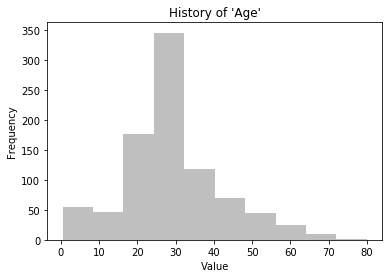

In [22]:
plot_hist(X['Age'])

In [23]:
# plot hist to shoe distribution of features by outcome categories
def plot_hist_d(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='die')
    plt.hist(list(x[y==1]), alpha=0.5, label='survived')
    plt.title("histogram of '{var_name}' by outcome category".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

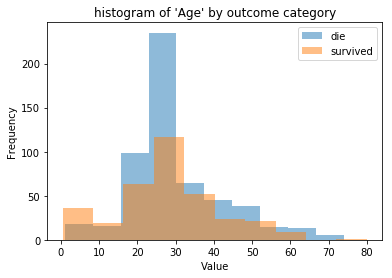

In [24]:
plot_hist_d(X['Age'],y)

In [25]:
# creating interactions between features
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_features(df):
    # first - get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # second - find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # last - remove interaction terms with all 0 values
    noint_indices = [i for i, x in  enumerate(list((df == 0).all()))if x]
    return df

In [26]:
X = add_features(X)
print(X.head(40))

    Pclass   Age  SibSp  Parch      Fare  Sex_female  Sex_male  Embarked_C  \
0      3.0  22.0    1.0    0.0    7.2500         0.0       1.0         0.0   
1      1.0  38.0    1.0    0.0   71.2833         1.0       0.0         1.0   
2      3.0  26.0    0.0    0.0    7.9250         1.0       0.0         0.0   
3      1.0  35.0    1.0    0.0   53.1000         1.0       0.0         0.0   
4      3.0  35.0    0.0    0.0    8.0500         0.0       1.0         0.0   
5      3.0  28.0    0.0    0.0    8.4583         0.0       1.0         0.0   
6      1.0  54.0    0.0    0.0   51.8625         0.0       1.0         0.0   
7      3.0   2.0    3.0    1.0   21.0750         0.0       1.0         0.0   
8      3.0  27.0    0.0    2.0   11.1333         1.0       0.0         0.0   
9      2.0  14.0    1.0    0.0   30.0708         1.0       0.0         1.0   
10     3.0   4.0    1.0    1.0   16.7000         1.0       0.0         0.0   
11     1.0  58.0    0.0    0.0   26.5500         1.0       0.0  

In [30]:
X.to_csv("ready_data.csv", encoding='utf-8', index=False)

In [32]:
ready_data = pd.read_csv("ready_data.csv")
ready_data.head(10)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Sex_female_Sex_male,Sex_female_Embarked_C,Sex_female_Embarked_Q,Sex_female_Embarked_S,Sex_male_Embarked_C,Sex_male_Embarked_Q,Sex_male_Embarked_S,Embarked_C_Embarked_Q,Embarked_C_Embarked_S,Embarked_Q_Embarked_S
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,3.0,28.0,0.0,0.0,8.4583,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.0,54.0,0.0,0.0,51.8625,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,3.0,2.0,3.0,1.0,21.0750,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,3.0,27.0,0.0,2.0,11.1333,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.0,14.0,1.0,0.0,30.0708,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Feature selection and model building
# first split out data into trains and tests
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=1)

In [54]:
#let's see how our data grow
print(d_train.shape)
print(X.shape)

(891, 8)
(891, 55)


In [55]:
import sklearn.feature_selection
select = sklearn.feature_selection.SelectKBest(k=20)
selected_features =select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]

C:\Users\Saleban\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [45 52 53 54] are constant.
  UserWarning)
C:\Users\Saleban\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [56]:
print(colnames_selected)

['Pclass', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Pclass_Age', 'Pclass_Fare', 'Pclass_Sex_female', 'Pclass_Sex_male', 'Pclass_Embarked_S', 'Age_Fare', 'Age_Sex_female', 'Age_Sex_male', 'SibSp_Embarked_C', 'Fare_Sex_female', 'Fare_Embarked_C', 'Sex_female_Embarked_C', 'Sex_female_Embarked_Q', 'Sex_female_Embarked_S', 'Sex_male_Embarked_S']


In [57]:
# build model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def find_model_perf(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_hat = [x[1] for x in model.predict_proba(X_test)]
    auc = roc_auc_score(y_test, y_hat)
    
    return auc

In [58]:
auc_processed = find_model_perf(X_train, y_train, X_test, y_test)
print(auc_processed)

0.843693460843


In [59]:
auc_processed.item()

0.843693460842595

In [60]:
pred = pd.read_csv("data/gender_submission.csv")
test

In [64]:
print(pred.shape)
print(d)

(418, 2)
